<a href="https://colab.research.google.com/github/Bobobert/RL_notebooks/blob/main/DQN_RL_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje por refuerzo profundo para juegos en Atari
## Libreta del algoritmo DQN.
*Por Roberto-Esteban López-Díaz*

El sabor de esta implementación es *vanilla* o la más básica, tal y como se describe en el paper original de Mnih et al del 2013 (https://arxiv.org/abs/1312.5602). Cabe mencionar que este trabajo como parte del equipo de investigación en video juegos de **DeepMind**. Algunas constantes salen de manera práctica por el entorno de ejecución de Colab (limitante) y el resto como se describen en los experimentos del articulo. 

Se tiene como meta presentar todos los elementos que confoman una implementación de DQN distinguiendo que cambios o elementos fueron necesarios para hacer al Q-Learning exitoso en el aprendizaje profundo. Mencionandolos rapidamente son:

- La arquitectura DQN
- Una memoria de experiencias
- La red objetivo



In [ ]:
# ML
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# Math and random
import numpy as np
import numpy.random as rdm
import math
# GYM
from gym.envs.atari import AtariEnv
# Image processing
import cv2 as cv
# Misc
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
# Some constants
MINI_BATCH_SIZE = 32
MEMORY_SIZE = 10**6
BUFFER_SIZE = 100
LHIST = 4
GAMMA = 0.99
UPDATE_FREQ_ONlINE = 4
UPDATE_TARGET = 2500 # This was 10**4 but is measured in actor steps, so it's divided update_freq_online
TEST_FREQ = 2.5*10**4 #5*10**4 # Measure in updates
TEST_STEPS = 10**4
LEARNING_RATE = 0.00025
G_MOMENTUM = 0.95
EPSILON_INIT = 1.0
EPSILON_FINAL = 0.1
EPSILON_TEST = 0.05
EPSILON_LIFE = 5*10**5 #10**6
REPLAY_START = 5*10**4
NO_OP_MAX = 30
UPDATES = 2*10**5 #5*10**6
CLIP_REWARD = 1.0
CLIP_ERROR = 1.0
# MISC
FRAMESIZE = [84,84]
FRAMESIZETP = (84,84)
FRAMETYPE = np.uint8

## Atari Learning Environment (ALE)
Este entorno está dentro de los muchos que ofrece [Gym](https://gym.openai.com/envs/#atari), [ALE](https://github.com/mgbellemare/Arcade-Learning-Environment) es usado por juego de atari solo se carga un distinto ROM. Para todos los juegos dispobles lo que suscede detrás del wrapper de gym es una emulación por parte de ALE en código C++ para Atari 2600. Existen, aparte de las dificultades normales del juego, disintos modos distintos al juego orignal que agregan más retos al agente de RL para aprender. De momento en esta libreta se hará uso del modo normal. 

Dentro de otras curiosidades, los entornos de ALE también ofrecen la opción de dar el estado interno del entorno en manera del *dump* de la RAM del emulador, para este trabajo se trabaja con información más general que sería la simple observación del entorno que en sí no podría o no reflejar el estado interno del juego.

Detalles a tocar sobre la implementación de DQN es añadir otro parametro al entorno de ALE, *frameskip* o salto de cuadros, esta función lo que hace en el entorno es después de ejecutar la acción en la llamada del método *.step()* se ejecutan otras $n - 1$ acciones vacias o nulas en el entorno para así dejar que pasen $n$ cuadros de la pantalla entre acciones.


En juegos de Atari la pantalla normalmente se actualiza cercana a los $\approx 60 \text{Hz}$, la técnica de saltar cuadros hace que el agente necesite aplicar solo $\frac{60 \frac{\text{ frames}}{s}}{n \frac{\text{frames}}{action}} = \frac{60}{n} \frac{\text{ actions}}{s}$ en el juego esto durante el entrenamiento no se hace para ahorrar tiempo, gracias a que el emulador correr tan rápido como el hardware moderno le perimite haciendo que en realidad inferencias y un acelador de ML se puedan ejecutar unas $800 \frac{\text{actions}}{s}$ reales ussando Python. En el articulo se propone usar $n=4$ para todos los juegos de sus pruebas a excepción de Space invaders con $n=3$. 

In [ ]:
# Making a function to generate any ALE environment.
makeEnv = lambda game: AtariEnv(game,
                                obs_type= 'image',
                                frameskip= 4 if game != 'space_invaders' else 3)

<class 'numpy.ndarray'> (210, 160, 3)


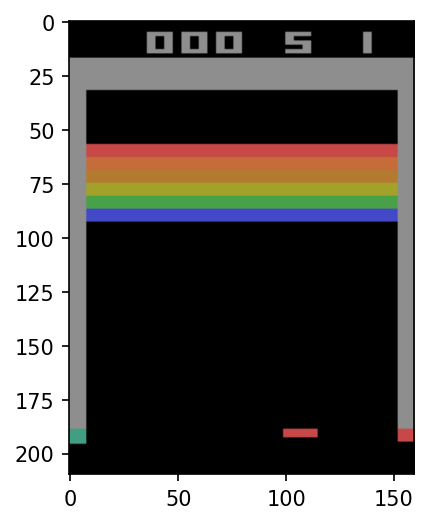

In [ ]:
# Testing the environments
testEnv = makeEnv("breakout")
obs = testEnv.reset()
plt.figure(dpi=150)
plt.imshow(obs)
print(type(obs), obs.shape)
del testEnv

## Procesamiento de la salida del entorno

Se dice que DQN toma la salida del entorno y bruto para hacer la estimación de la función de valores. Sin embargo, esto no es del todo cierto como tal. 
Aunque el procesamiento a las imagenes es en realidad sencillo y sin agregar conocimiento previo alguno, es necesario como practicas para ingresar imagenes a redes profundas convolucionales normalizarlas. Y con motivo de reducir dimesionalidad, se eliminan las dimesiones del color pasando solo el canal de luma **Y** (depsués de una conversión al espacio de color YUV). 

Después, se reescala la imagen a una dimensión cuadrada de $84\times 84$ pixeles. Esta dimesion podría considerarse "caprichosa" ¿por que no hacerla más grande o pequeña? en realidad hay buenos motivos para no hacerla hacerla más pequeña, y lo grande claro que mientras más grande la dimesión de nuestro "estado" será mayor, pero también la de la red DQN consumiendo más recursos. Esta fue solo otra desición de diseño con justificación empirica detrás.

In [ ]:
def procFrame(frame):
    global FRAMESIZETP
    YChannel = cv.cvtColor(frame, cv.COLOR_RGB2YUV)[:,:,0]
    return cv.resize(YChannel, FRAMESIZETP) #opencv2 python returns a ndarray

<class 'numpy.ndarray'> (84, 84)
Snip of the frame [142 142 142 142 129 129 129 129 129 129]


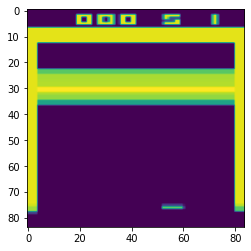

In [ ]:
# Testin output
obsProc = procFrame(obs)
print(type(obsProc), obsProc.shape)
print("Snip of the frame", obsProc[25,0:10])
plt.imshow(obsProc)

## Arquitectura aprixmadora de valores Q: **DQN**
El aproximador paramétrico de la función de valores Q para este trabajo esta basado en técnicas de aprendizaje profundo, en espefico las redes neuronales convolucionales para extraer caracteristicas del estado formado por historia de las observaciones que estan formadas por las imagenes de salida del atari después de un preprocesamiento. El nombre del agoritmo nace del uso de esta arquitectura a la cual se le llama **Deep Q-Network**. El proceso de la arquitectura en sí, se podría interepretar como la busqueda de una representación del estado interno del entorno que queda representada por la salida de las capas convolucionales. 

Mientras que la segunda parte con las capas totalmente conectadas queda como el aproximador de valor del estado dadas las acciones que se pueden tomar (Valores Q).

Todo el trabajo sobre DQN es darle lo menos a nada información previa o espcifica al algoritmo sobre el entorno y a la red convolucional más que la entrada de imagenes en "burto". Esta es una característica muy atractiva de este algoritmo.


El resultado de usar este aproximador se resume que se tiene la salida de los valores Q dada la entrada de la historia en el tiempo $t$ respecto a los parámetros $\theta$ (pesos y sesgos de la red). 

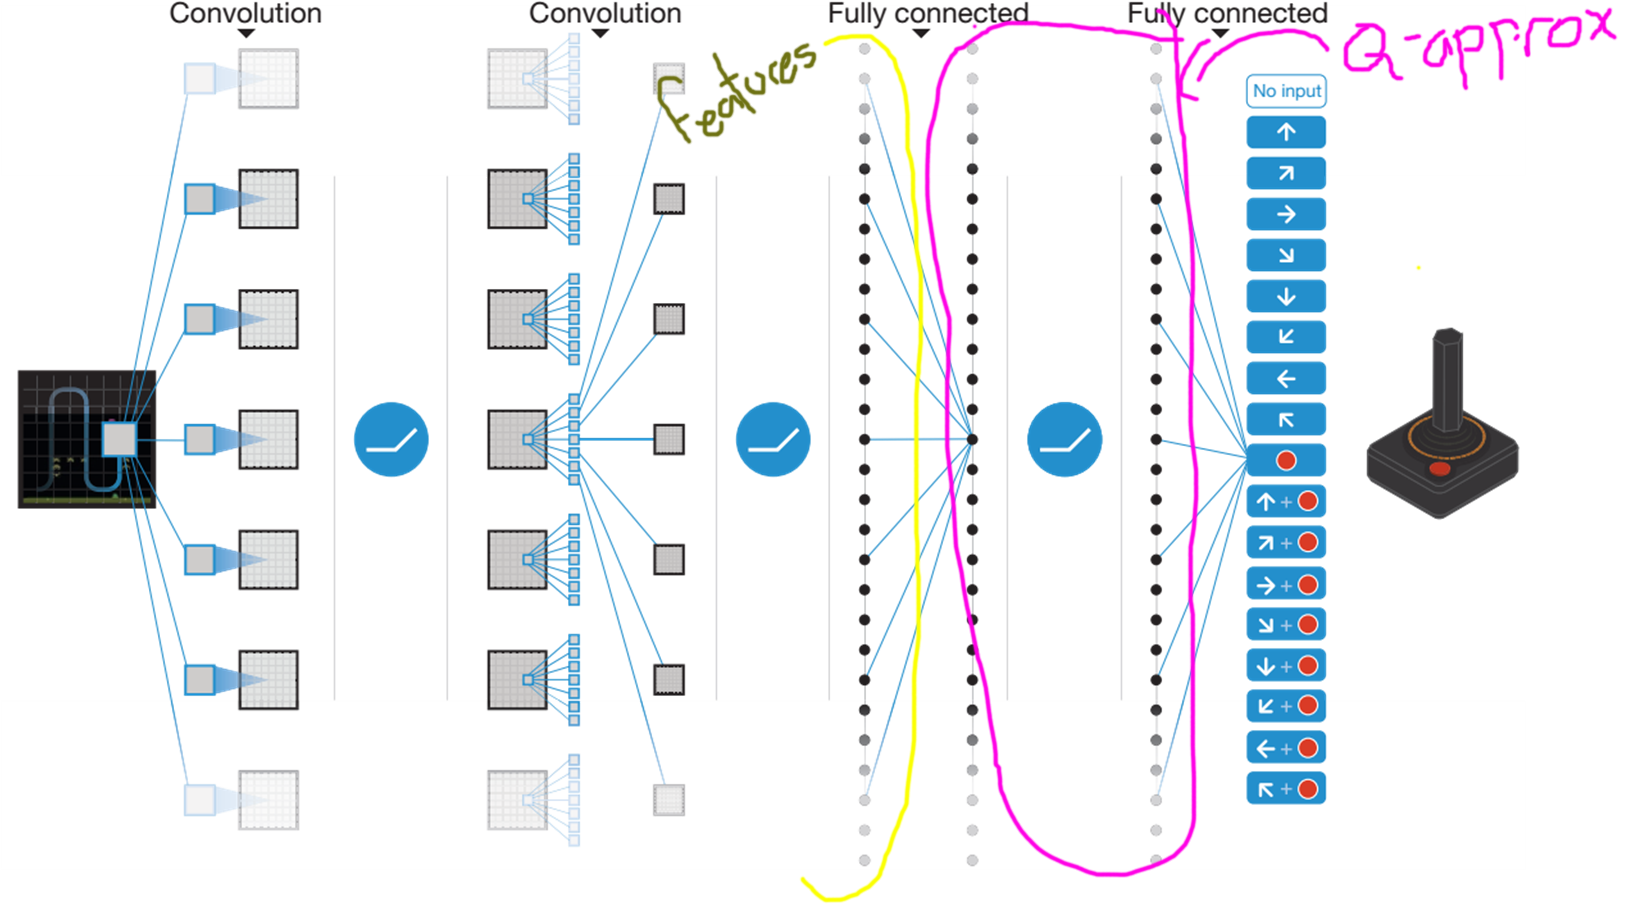


In [ ]:
class atariDQN(nn.Module):
    """
    Policy network for DQN-Atari

    parameters
    ----------
    lHist: int
        Number of frames on the stack for a history. The frame size 
        is defined as (84, 84)
    actions: int
        Number of actions in which the policy will chose
    """
    def __init__(self, lHist:int = 4, actions:int = 18):
        super(atariDQN, self).__init__()
        # Variables
        self.lHist = lHist
        self.outputs = actions
        # Net
        self.rectifier = F.relu
        self.cv1 = nn.Conv2d(lHist, 32, 8, 4)
        self.cv2 = nn.Conv2d(32, 64, 4, 2)
        self.cv3 = nn.Conv2d(64, 64, 3, 1)
        self.fc1 = nn.Linear(3136, 512) # 3136 is the restul from the expected final
        # of the "image per 64 filters. See the strides and the expected 84x84 image
        self.fc2 = nn.Linear(512, actions) # from fully connected to actions

    def forward(self, X):
        X = self.cv1(X)
        X = self.rectifier(X)
        X = self.cv2(X)
        X = self.rectifier(X)
        X = self.cv3(X)
        X = self.rectifier(X)
        X = self.fc1(X.flatten(1))
        X = self.rectifier(X)
        return self.fc2(X)
        
    def copy(self):
        new = atariDQN(self.lHist, self.outputs)
        new.load_state_dict(self.state_dict())
        return new

    def updateState(self, stateDict):
        self.load_state_dict(stateDict, strict=True)

    def getState(self, cpu:bool=False):
        if not cpu:
            return self.state_dict()
        else:
            stateDict = self.state_dict()
            for key in stateDict.keys():
                stateDict[key] = stateDict[key].to(torch.device('cpu'))
            return stateDict

## Experience Replay
Otro de los elementos clave para aplicar DQN ha sido la introducción de la memoria de experiencias o rejugabilidad de experiencias (traducción a mejorarse). Este elemento auxilia a romper las correlaciones entre las experiencias, y forma los mini lotes (mini batches) de estas para calcular el TD-target para que DQN pueda *aprender* de ellas sin introducir mucha inestabilidad (por la condición de Independientes e Identicamente Distribuidos de los datos, *i.i.d.*, que en las experencias secuenciales no cumplen en sí por estar altemente correlacionadas). Estas caracterisiticas son propias de la arquitectura de DQN y que provienen de técnicas de aprendizaje profundo.

Se puede definir formalemente como el conjunto finito de experiencias que el agente tiene durante su entrenamiento $\mathit{D}={e_1,e_2,\dots,e_t}$, dónde una experiencia se puede definir como la tupla $e=(s_t, a_t,r_{t+1}, s_{t+1})$. La estructura de este conjunto en implementación se puede ver como una pequeña base de datos secuencial de manera que los primeros datos en entrar son los primeros en salir (First-In-First-Out,FIFO) en cuanto este conjuto alcanza su limite de memoria. 

La manera en la que la implementación *vanilla* del algoritmo, para hacer los mini lotes de expericias es escogerlos de manera uniforme entre todas las disponibles, esto es darles la misma *importancia* a cada una.

Este elemento de software se puede programar de muchas formas, más generales o más AdHoc, a continuación para intentar administrar propiamente los recursos, es un mecánismo diseñado con las imagenes de la salida del atari en mente. De integrar otro tipo de entorno, podría requerir de modificaciones para dicho cambio.

In [ ]:
class MemoryReplay(object):
    """
    Main Storage for the transitions experienced by the actor.

    It has methods to Sample, combineBuffers

    Parameters
    ----------
    capacity: int
        Number of transitions to store
    state_shape: list or tuple
        Contains the expected dimensions of the history's images
    LHist: int
        Number of frames of experience to form a history. This
        shall be greater than 0.
    Other related to dtypes.
    """
    def __init__(self,
                 capacity:int = MEMORY_SIZE,
                 state_shape:list = [84, 84],
                 LHist:int = LHIST,
                 state_dtype_in:np.dtype = np.uint8,
                 state_dtype_out:np.dtype = np.float32,
                 action_dtype_in:np.dtype = np.uint8,
                 action_dtype_out:torch.dtype = torch.int64,
                 reward_dtype_in:np.dtype = np.float32,
                 reward_dtype_out:torch.dtype = torch.float32,
                 ):
        
        self.s_in_shape = state_shape
        self.s_dtype_in = state_dtype_in
        self.s_dtype = state_dtype_out
        self.a_dtype = action_dtype_out
        self.r_dtype = reward_dtype_out

        self.capacity = capacity
        self.LHist = LHist
        self.shapeHistOut = [LHist] + state_shape
        self._i = 0
        self.FO = False

        self.s_buffer = np.zeros([capacity]+state_shape, dtype = state_dtype_in)
        self.a_buffer = np.zeros(capacity, dtype = action_dtype_in)
        self.r_buffer = np.zeros(capacity, dtype = reward_dtype_in)
        self.t_buffer = np.ones(capacity, dtype = np.bool_) # Inverse logic

    def add(self, s, a, r, t):
        """
        Add one item
        """
        self.s_buffer[self._i] = s
        self.a_buffer[self._i] = a
        self.r_buffer[self._i] = r
        self.t_buffer[self._i] = t
        self._i = (self._i + 1) % self.capacity
        if self._i == 0:
            self.FO = True

    def __getitem__(self, i:int):
        if i < self._i or self.FO:
            i = i % self.capacity
            return (self.s_buffer[i],
                    self.a_buffer[i],
                    self.r_buffer[i],
                    self.t_buffer[i])
        else:
            return self.zeroe

    @property
    def zeroe(self):
        return (np.zeros(self.s_in_shape, dtype=self.s_dtype_in),
                0,
                0.0,
                False)

    def Sample(self, mini_batch_size:int, tDevice = torch.device('cpu')):
        """
        Process and returns a mini batch. The tuple returned are
        all torch tensors.
        
        If tDevice is cpu class, this process may consume more cpu resources
        than expected. Could be detrimental if hosting multiple instances. 
        This seems expected from using torch. (Y)

        Parameters
        ---------
        mini_batch_size: int
            Number of samples that compose the mini batch
        tDevice: torch.device
            Optional. Torch device target for the mini batch
            to reside on.
        """
        assert mini_batch_size > 0, "The size of the mini batch must be positive"

        if self._i > mini_batch_size + self.LHist or self.FO:
            #ids = rdm.choice(np.arange(self.LHist, self.capacity if self.FO else self._i - 1), 
            #                        size=mini_batch_size, replace=False)
            ids = rdm.randint(self.LHist, self.capacity if self.FO else self._i - 1, 
                                    size=mini_batch_size)
            st1 = np.zeros([mini_batch_size] + self.shapeHistOut, 
                           dtype = self.s_dtype)
            st2 = st1.copy()
            for m, i in enumerate(ids):
                for n, j in enumerate(range(i, i - self.LHist - 1, -1)):
                    s, _, _, t = self[j]
                    if n < self.LHist:
                        st2[m][n] = s.copy()
                    if n > 0:
                        st1[m][n - 1] = s.copy()
                    if not t and n >= 0:
                        # This should happend rarely
                        break
            at = self.a_buffer[ids]
            rt = self.r_buffer[ids]
            terminals = self.t_buffer[ids].astype(np.float32)
            # Passing to torch format
            st1 = torch.as_tensor(st1, device=tDevice).div(255).requires_grad_()
            st2 = torch.as_tensor(st2, device=tDevice).div(255)
            terminals = torch.as_tensor(terminals, dtype=torch.float32, device=tDevice)
            at = torch.as_tensor(at, dtype=self.a_dtype, device=tDevice)
            rt = torch.as_tensor(rt, dtype=self.r_dtype, device=tDevice)
            return (st1, at, rt, st2, terminals)
        else:
            raise IndexError("The memory does not contains enough transitions to generate the sample")

    def combineBuffers(self, *buffers):
        """
        Pass any number of tuples with buffers to add to the
        memory replay.
        """
        for buffer in buffers:
            # Unpack
            st_other, at_other, rt_other, t_other = buffer
            # Adding a zero between buffers
            if len(buffers) > 1:
                self.add(*self.zeroe)
            # Update buffers
            l = t_other.shape[0]
            if l + self._i > self.capacity:
                ovr = (l + self._i) % self.capacity
                ovrl = (self.capacity - self._i)
                self.s_buffer[self._i:] = st_other[:ovrl]
                self.a_buffer[self._i:] = at_other[:ovrl]
                self.r_buffer[self._i:] = rt_other[:ovrl]
                self.t_buffer[self._i:] = t_other[:ovrl]
                self.s_buffer[:ovr] = st_other[ovrl:]
                self.a_buffer[:ovr] = at_other[ovrl:]
                self.r_buffer[:ovr] = rt_other[ovrl:]
                self.t_buffer[:ovr] = t_other[ovrl:]
            else:
                self.s_buffer[self._i:self._i + l] = st_other
                self.a_buffer[self._i:self._i + l] = at_other
                self.r_buffer[self._i:self._i + l] = rt_other
                self.t_buffer[self._i:self._i + l] = t_other
            ax = (self._i + l)
            if ax >= self.capacity:
                self.FO = True
            self._i = ax % self.capacity
        del buffers

    def __len__(self):
        if self.FO:
            return self.capacity
        else:
            return self._i

    def reset(self):
        self._i = 0
        self.FO = False
        self.t_buffer[:] = True

### Observaciones y Estados en DQN Atari

Recordando la diferencia entre observaciones y estados de un entorno, ¿sería suficiente una o la secuencias de imagenes solas para representar el estado del entorno?. Para responder esa pregunta habría que poner en concreto cual es el estado completo del entorno que cumpla con las propiedades necesarias. En esta tarea se usa una funcion $\phi$ de preprocesamiento a las observaciones que regresa el entorno para intentar formar un semblante a lo que la historia.

Acomodando de manera sencuencial $n$ cuadros de imagen disponibles para un instante $t$ esto es $\phi(H_t)\approx{O_{t-n+1}, O_{t-n+2}, \dots, O_t}$; aunque faltarían otros elementos como acciones y recompensas para ser formalmente la historia. Esta acción no es formar estrictamente el estado, sino , que se hace con afán de darle suficiente información a DQN para que pueda inferir el estado o las características relvantes a este y apartir de eso inferir también los valores Q para dicho estado. Esta es una propiedad interesante de DQN, que hace todo eso con una sola pasada hacia delante en su arquitectura haciendo las implementaciones on-line rápidas (de tener un acelarador de ML, ejemplos serían las soluciones de nVidia y Apple).

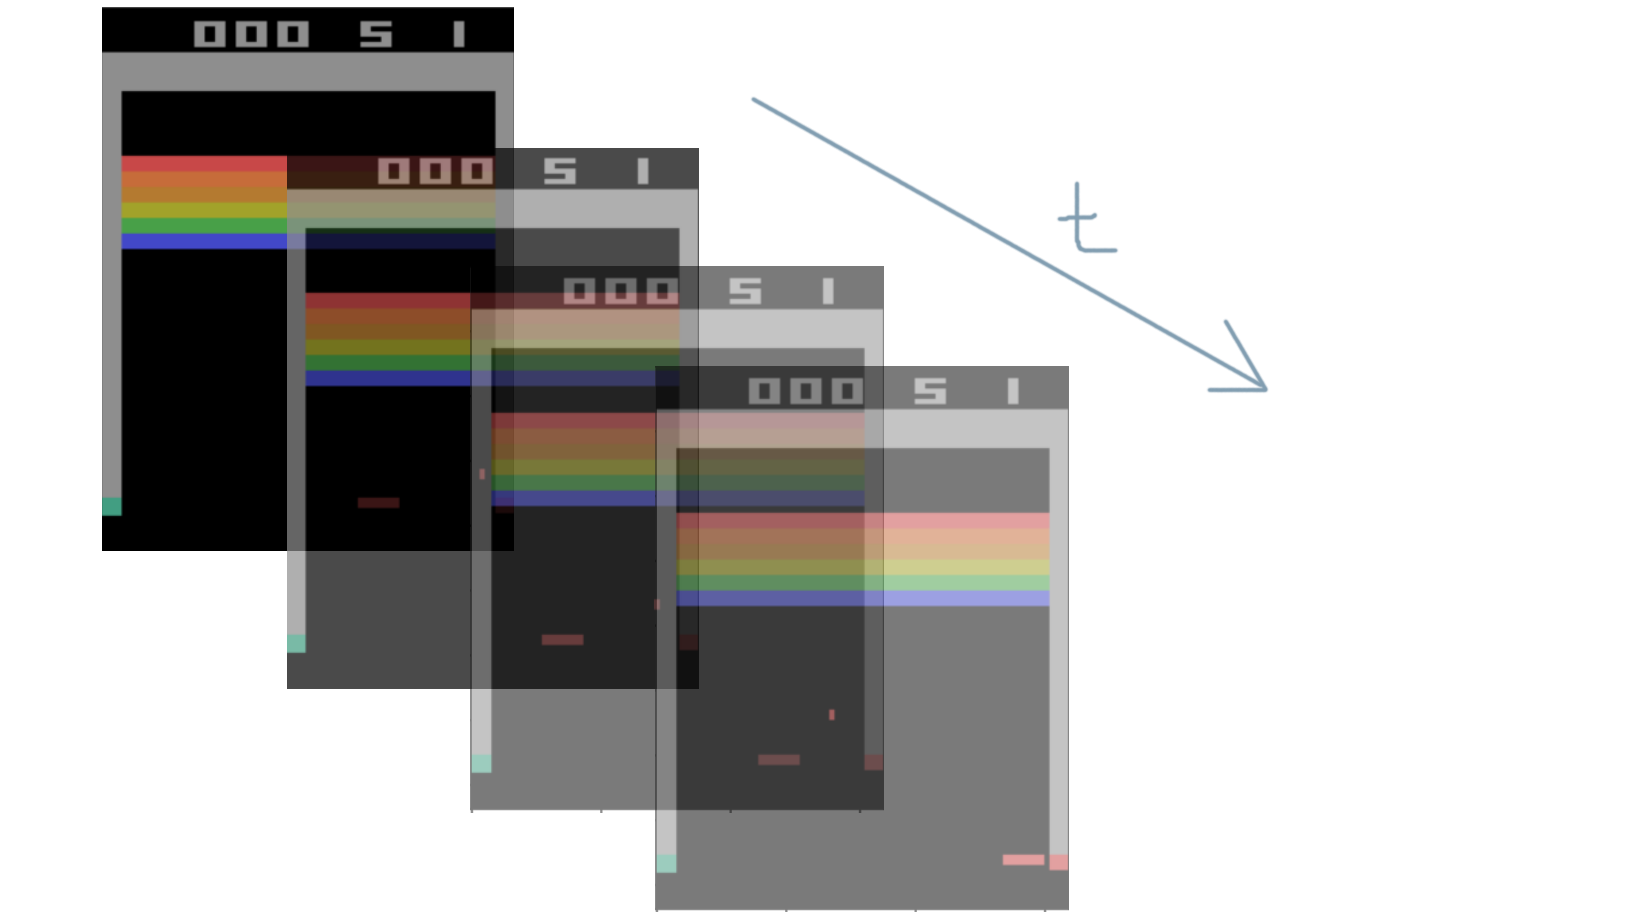

## Entrenamiento

Con los elementos anteriores, ahora se adentra en el entrenamiento propuesto para DQN. Dado que el aproximador usado es para predicir el valor de la función acción-valor *Q*, se utiliza uno de los algoritmos basados en diferenciales temporales (Temporal Difference, TD) *Q-Learning*. Con el TD-Error $\delta$ como su base para actualizar los parametros de la red DQN, cuidando reconocer los estados terminales con la bandera de *done* para asignarles valor de 0 siempre. 

$\delta = R_{t+1} + \gamma \max_{a'} Q(S_{t+1},a'; \theta_i)-Q(S_t ,a_t; \theta_i)$

Donde $\theta_i$ es el conjunto de parametros que contenga el aproximador en un instante $i$ de su entrenamiento.

La elección de usar *Q-Learning* para formar las actualizaciones, esta dada por ser un algoritmo *off-policy*, y presumiblemente la rapidez que bootstapping podría ofrecer. La intención de tener el elemento *experience-replay* será guardar jugadas previas que una o varias politicas formaron a lo largo del proceso, dejando así poca alternativa en cuanto que tipo de actualización usar. Extrictamente tendrá que ser del tipo *off-policy*.

Otro problema sería utilizar la expresión anterior como tal para la actualización de la red. Esta podría provocar problemas severos en el aprendizaje. Dado que se está estimando el error cada vez con el mismo conjunto de parámetros a actualizar. Este tipo de actualización introduce un sesgo muy grande sobre las siguientes acciones cuyas observaciones podrían ser muy similares y dado los nuevos estimados tendería ir por ese camino que podría ser una pobre elección. Añadiendo al problema, si el estimado del siguiente estado es malo, por naturaleza de TD se corregirá prestando a un movimiento oscilante de la red, provocando un apendizaje malo o que pueda tender a divergir. 

Es aquí donde el segundo elemento permite a DQN ser entrenado con *Q-learning*.  El uso de un segundo conjunto de paramétros $\theta'_i$, que son copia del conjunto original $\theta_i$ pero con un desfase en los pasos de entrenamiento o actualizaciones. Es decir, que este conjunto es el mismo que era $\theta_i$ una cantidad $\tau$ de actuliazciones atrás. A este conjunto nuevo $\theta_i'$ se le llama la red objetivo (target network), mientra que al conjunto $\theta_i$ se le designa red en linea (on-line network). La práctica de generar la red objetivo es evitar el comportamiento oscilante del TD-Error y así prever las oscilaciones inecesarias de valores en la red en linea mientras se actualiza por cada paso. Con esta modificación la actualización de DQN se expresa como

$\delta_{\text{DQN}} = R_{t+1} + \gamma \max_{a'}Q(S_{t+1},a'; \theta_i') - Q(S_t, A_t; \theta_i)$

El suepuesto que para utilizar DQN, o *Q-learning* en general, está en la reducción los entornos a un proceso de decisión de Markov(MDP). El entorno de Atari 2600 se puede reducir a un MDP. 

Para la actualización de la red DQN, la mera cantidad de $\delta$ podría no parecer suficiente o incluso problematica para los practicantes de aprendizaje de máquina. Para ello Mnih et al. proponen las siguientes observaciones de como tratar esta cantidad:

- Dado que las recompensas dependen de cada entorno o juego en especifico, se proponer pasarlas por la funcion *clip* con el intervalo de $[-1,1]$.
- Al momento de calcular la cantidad de TD-Error, esta aun asi podría ser muy grande con efectos negativos al aprendizaje de la red. Por lo que se propone también hacerle un *clip* como a la recompensa. Este punto viene como tal en ambos articulos publicados por el equipo de Deepmind, sin embargo en la práctica no parece dar buenos resultados implemetarlo como proponen (haciendo un clip sobre el gradiente). Se propone en vez, utilizar una función de perdida tal como la de *Hubber* (en pytorch su implementación está bajo el nombre de smooth l1 loss), que es similar a como describen en sus formulaciones matemáticas $L_i(\theta_i) = \mathbb{E}_{s,a\sim\rho(\cdot)}[(\delta_{\text{DQN}})^2 | S_t=s, A_t=a]$

Dada la nueva expresión de perdida que ahora queda expresada en dos conjuntos de parámetros, es interesante ver su derivada respecto al conjunto $\theta_i$ de la red en línea.

$\bigtriangledown_{\theta_i}L(\theta_i)=\mathbb{E}_{s,a,r,s'}\big[\delta_{\text{DQN}}\bigtriangledown_{\theta_i}Q(S_t,a_t;\theta_i) | S_t =s,A_t=a \big]$


### Detalles de implementación
#### Actores
La siguiente implementación anterior no se podría considerar como la única o nisquiera la mejor para una ejecución rápida, que generar varios objetos puede tener efecto sobre la memoria; aunque sean por algunos MB. Pero tiene sus ventajas generar las clases Actor y Aprendiz, en primer lugar es la modularidad, se pueden cambiar o corregir métodos sencillamente sin inteferir en otros procesos. La otra sería generar métodos complejos para llamadas sencillas, así al momento de experimentar; una vez probada su funcionamiento correcto, se pueden hacer cambios de los parámetros de manera sencilla sin manipular directamente los métodos.

Ampliando las ventajas que podría encontrar con esta práctica son implementar soluciones dónde se generen varias de estos objetos por experimiento para habilitar un aprendizaje paralelo, para DQN de forma [asíncrona](http://proceedings.mlr.press/v48/mniha16.pdf).

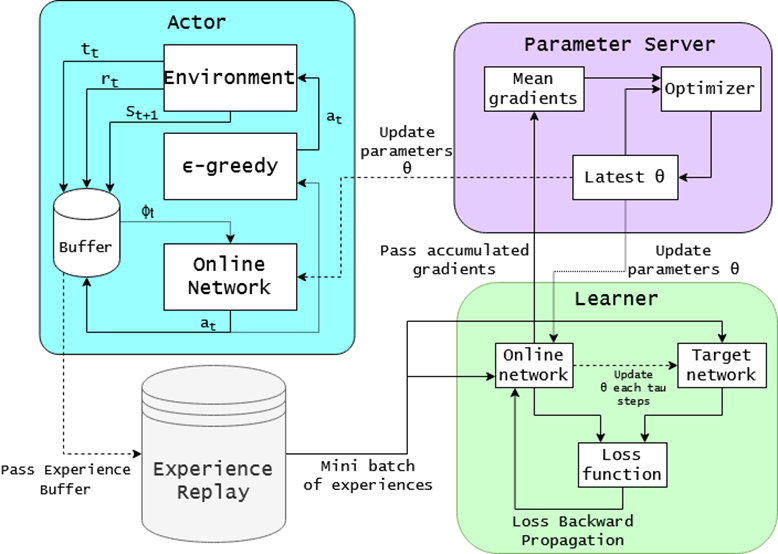


In [ ]:
class ActorDQN():
    """
    Actor to host an excecute a gym environment for atari games.
    
    Paramenters
    -----------
    game: str
        Name of the game to execute.
    gameActions: int
        Number of actions that the agent can execute.
        If doubt check the actions in CONST.ACTION_MEANING
    policy: torch policy
        Object that hosts the policy network to process the
        environment's observations.
    
    """
    def __init__(self,
                game:str,
                gameActions:int,
                policy,
                lHist: int = 4,
                steps_per_update:int = 4,
                test_steps:int = TEST_STEPS,
                epsilon:float = EPSILON_INIT,
                epsilon_final:float = EPSILON_FINAL,
                epsilon_test:float = EPSILON_TEST,
                epsilon_life:int = EPSILON_LIFE,
                buffer_size:int = BUFFER_SIZE,
                start_steps: int = REPLAY_START,
                start_noop_max:int = NO_OP_MAX,
                clip:float = CLIP_REWARD,
                seed:int = -1,
                device = torch.device('cpu'),
                ):
        
        self.seed = seed if seed >= 0 else None
        self.rg = np.random.Generator(np.random.PCG64(self.seed))

        buffer_size = buffer_size * lHist
        self.sBuffer = np.zeros([buffer_size] + FRAMESIZE, dtype=FRAMETYPE)
        self.aBuffer = np.zeros(buffer_size, dtype=FRAMETYPE)
        self.rBuffer = np.zeros(buffer_size, dtype=np.float32)
        self.tBuffer = np.zeros(buffer_size, dtype=np.bool_)
        self._i = 0
        self.bufferFull = False
        self.buffer_size = buffer_size
        self.lHist = lHist
        self.lastObs = None
        
        self.game = game
        self.n_actions = gameActions
        self.actionsT = torch.tensor(range(gameActions), 
                                        dtype=torch.int64,
                                        device=device).unsqueeze(0)
        self.lives = None
        self.setGame(game)
        self.done = True

        self.device = device
        self.policy = policy # Just a reference to the net

        self._epsilon_start = epsilon
        self._epsilon_end = epsilon_final
        self._epsilon_life = epsilon_life
        self._epsilon_test = epsilon_test
        self.noop_max = start_noop_max
        self.clip = clip

        self.steps = 0
        self.episodes = 0
        self.steps_per_update = steps_per_update
        self.steps_per_test = test_steps
        self.testSteps = 0
        self.testEpisodes = 0
        self.isTest = False
        self.test_histories_steps = 0
        self.start_steps = start_steps
        self.test_histories = None

    def setGame(self, game):
        self.env = makeEnv(game)
        print("Game {} is set up!".format(game))
        if self.env.action_space.n != self.n_actions:
            print("Actions given {} don't match the environment {}".format(
                            self.n_actions ,self.env.action_space.n))
        if self.seed is not None: 
            self.env.seed(self.seed)
        
    def newGame(self):
        obs = self.env.reset()
        done = False
        if self.isTest:
            for _ in range(self.rg.integers(0, self.noop_max)):
                # Actions with no-op at the start for a random number of steps
                obs, _, done, _ = self.env.step(0)
        self.updateBuffer(obs, 0, 0, done)
        self.lives = self.env.ale.lives()
        self.done = done
    
    def procFrame(self,f):
        return procFrame(f)
    
    def updateBuffer(self, st1, at, rt, terminal):
        """
        Saves the information of the transition from a step of
        the environment, this is s_{t+1}, a_t, r_t, terminal_{t+1}.
        Meaning it saves the new observation from P(s_t, a_t), s_t
        should be the previous item in sBuffer.

        The tBuffer uses not-logic. True when not-terminal and 
        False for terminal states.
        """
        st1 = self.procFrame(st1)
        if self.clip > 0.0:
            rt = np.clip(rt, -self.clip, self.clip)
        self.sBuffer[self._i] = st1
        self.aBuffer[self._i] = at
        self.rBuffer[self._i] = rt
        self.tBuffer[self._i] = not terminal
        self._i = (self._i + 1) % self.buffer_size
        if self._i == 0:
            self.bufferFull = True

    def getTransition(self):
        i = self._i - 1
        transition = (self.sBuffer[i].copy(),
                        self.aBuffer[i].copy(),
                        self.rBuffer[i].copy(),
                        self.tBuffer[i].copy())
        return transition

    def clearBuffer(self):
        self.bufferFull = False
        self._i = 0
        self.tBuffer[:] = False
        self.done = True
        self.lastObs = None

    def getState(self):
        """
        Returns from buffer the last composite history by Phi
        on the time t.
        """
        lastObs = torch.zeros((self.lHist, FRAMESIZE[0], FRAMESIZE[1]),
                                    dtype=torch.float32)
        for i in range(self.lHist):
            j = self._i - i - 1
            if i > 0 and not self.tBuffer[j]:
                break
            lastObs[i] = torch.from_numpy(self.sBuffer[j])
        return lastObs.unsqueeze(0).to(self.device).div(255)

    def updateModel(self, state_dict):
        self.policy.updateState(state_dict)

    @property
    def Steps(self) -> int:
        return max(0, self.steps - self.start_steps)

    @property
    def epsilon(self) -> float:
        """
        Returns the current value of epsilon given the configurations.
        """
        if self.isTest:
            return self._epsilon_test
        steps = self.Steps
        if steps > self._epsilon_life:
            return self._epsilon_end
        else:
            m = (self._epsilon_end - self._epsilon_start) / (self._epsilon_life)
            return self._epsilon_start + m * steps

    def step(self, dry=False):
        """
        Main method to do a step on the environment.
        Resets or change environment automatically when
        then current environment is done.
        Adds the current obsevations to the buffer and 
        clips the reward if needed.

        If dry is True always executes a random action.
        Returns
        -------
        reward:float
        """
        if self.done:
            self.newGame()
        if dry:
            action = self.randomAction()
        else:
            action =  self.calculateAction()
        obs, reward, done, info = self.env.step(action)

        obs_lives = info['ale.lives']

        # Reboots in training when it lost a life
        # It does not apply when dry mode or test
        if obs_lives == self.lives or dry or self.isTest:
            self.updateBuffer(obs, action, reward, done)
        else:
            self.updateBuffer(obs, action, reward, True)

        self.lives = obs_lives
        self.done = done

        # Updating counters
        if self.isTest:
            self.testSteps += 1
            self.testEpisodes += 1 if self.done else 0
        else:
            self.steps += 1
            self.episodes += 1 if self.done else 0
        return reward

    def autoStep(self):
        """
        Does n steps_per_update in the environment. Accumulates the experiences
        in its buffer. Returns the flag when the buffer is full
        """ 
        for i in range(self.steps_per_update):
            _ = self.step()
        return self.bufferFull

    def calculateAction(self):
        if self.rg.uniform() <= self.epsilon:
            # Epsilon step
            return self.randomAction()
        else:
            # Greedy step
            lastObs = self.getState()
            with torch.no_grad():
                output = self.policy.forward(lastObs)
                q_max = output.max(1).values.item()
                actions = self.actionsT[output.ge(q_max)]
            del lastObs, output
            return self.rg.choice(actions.to('cpu'))

    def randomAction(self):
        return self.rg.integers(self.n_actions)

    def testRun(self):
        """
        Executes a whole test run with the actual policy state.

        returns
        -------
        rewards_episode: list
            Contains all the accumulate reward by episode.
        """
        self.isTest = True
        self.clearBuffer()
        episode_reward = 0
        rewards_episode = []
        for step in range(self.steps_per_test):
            episode_reward += self.step()
            if self.done:
                rewards_episode += [episode_reward]
                episode_reward = 0
        self.isTest = False
        self.clearBuffer()
        if rewards_episode == []:
            rewards_episode = [episode_reward]
        return rewards_episode
    
    def testQHistories(self):
        if self.test_histories is None:
            return 0.0
        with torch.no_grad():
            model_out = self.policy(self.test_histories)
            mean = torch.mean(model_out.max(1).values).item()
        self.test_histories_steps += 1
        del model_out
        return mean

    def passTestHistories(self, histories):
        self.test_histories = histories.to(self.device)

    def getBuffer(self):
        Buffers = (self.sBuffer.copy(), self.aBuffer.copy(), 
                    self.rBuffer.copy(), self.tBuffer.copy())
        self.bufferFull = False
        return Buffers

    def fillBuffer(self):
        self.clearBuffer()
        for _ in range(self.buffer_size):
            self.step(dry = True)
        return self.getBuffer()

class LearnerDQN():
    """
    Actor that manages the samples and learn the transitions
    with the policy passed.

    Parameters
    ----------
    """
    def __init__(self,
                policy,
                memory,
                mini_batch_size:int = MINI_BATCH_SIZE,
                gamma:float = GAMMA,
                update_target:int = UPDATE_TARGET,
                learning_rate:float = LEARNING_RATE,
                momentum:float = G_MOMENTUM,
                clip_error:float = CLIP_ERROR,
                optimizer:str = 'adam',
                seed:int = -1,
                device = torch.device('cpu'),
                ):

        self.seed = seed if seed >= 0 else None
        self.rg = np.random.Generator(np.random.PCG64(self.seed))

        self.gamma = gamma
        self.clip = clip_error
        self.miniBatch_size = mini_batch_size

        self.device = device
        self.target_net = policy.copy().to(device)
        self.online_net = policy.to(device)
        self.n_actions = policy.outputs
        
        self.memory = memory # Reference

        if optimizer == 'rmsprop':
            self.optimizer = optim.RMSprop(self.online_net.parameters(), 
                                        lr= learning_rate, alpha=momentum,
                                        eps=0.00001, centered=True)

        elif optimizer == 'adam':
            self.optimizer = optim.Adam(self.online_net.parameters(),
                                        lr=learning_rate,)

        self.steps = 0
        self.update_target = update_target

    def trainStep(self):
        """
        Executes a simple learning step with a mini batch from
        the memory replay.\n
        It updates its target network automagically.
        """
        s1, a, r, s2, t = self.memory.Sample(self.miniBatch_size, self.device)
        actions_hot = F.one_hot(a, num_classes=self.n_actions)
        q_online = self.online_net.forward(s1)
        q_online = torch.mul(q_online, actions_hot)
        q_target = self.dqnTarget(s2, r, t)
        q_target = torch.mul(q_target, actions_hot)

        # Hubber Loss
        loss = F.smooth_l1_loss(q_online, q_target, reduction='mean')

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.steps % self.update_target == 0:
            # Updates the net
            self.updateTargetModel(self.onlineModel())
        self.steps += 1

    def dqnTarget(self, s2, r, t):
        with torch.no_grad():
            model_out = self.target_net.forward(s2)
            Qs2_max = model_out.max(1)[0]  
            target = r + torch.mul(t, Qs2_max).mul(self.gamma).reshape(r.shape)
        return target.unsqueeze(1)

    def onlineModel(self, cpu:bool = False):
        return self.online_net.getState(cpu)

    def updateOnlineModel(self, new_state):
        self.online_net.updateState(new_state)

    def targetModel(self):
        return self.target_net.getState()

    def updateTargetModel(self, new_state):
        self.target_net.updateState(new_state)

### Optimizador
Otro detalle encontrado  durante la práctica, es sobre la recomendación o el uso de RMSProp con los parámetros que el articulo original dice haber usado no dan buenos resultados a como se reportan. Este comportamiento podría estar dado que los autores tienen otra implementación del optimizador a los disponibles a las paqueterias como la de Pytorch. Afortunadamente, optimizadores como Adam dan muy buenos resultados en DQN que es la alternativa que se ofece en el objeto del Aprendiz.

Encontrando análogos al *Q-leaning* ordinario, los optimizadores auxilian con la tarea de actualizar el conjunto de parámetros de la red en la dirección del gradiente, la diferencia es el tamaño del paso del aprendizaje $\alpha$ por actualización. Este se va ajustando dependiendo del algoritmo del optimizador que se esté usando.

### Exploración

El comportamiento de la exploración en el agoritmo de DQN utiliza la política $\epsilon\text{-greedy}$ con epsilon decayendo de manera lineal respecto a los pasos que da el agente en el entorno durante el aprendizaje. Para la evaluación del rendimiento del agente, se utiliza el mismo tipo de política pero con una cantidad constante de $\epsilon=0.05$. 

Epsilon decae como se muestra a continuación.

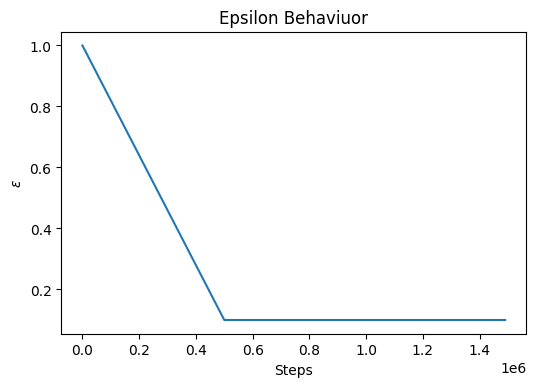

In [ ]:
X = np.arange(0,1.5*10**6,10**4)
y = [(EPSILON_INIT - EPSILON_FINAL) * (1 - (x/EPSILON_LIFE)) + EPSILON_FINAL if x <= EPSILON_LIFE else EPSILON_FINAL for x in X]
plt.figure(dpi=100)
plt.title("Epsilon Behaviuor")
plt.xlabel("Steps")
plt.ylabel("$\epsilon$")
plt.plot(X,y)

### Algoritmo de aprendizaje

El algoritmo de DQN comparte todos los elementos generales con el algoritmo de Q-Learning, en cuanto a sus progresiones de aprendizaje. Las diferencias clave son las siguientes:
- Antes de aprender se inicializa la memoria de experiencias con un número inicial de experiencias con una politíca totalmente aleatoria. Esto es para tener memorias disponibles para las primeras actualizaciones.
- Por cada paso que da el agente en el entorno, en vez de actualizar la función de valores Q con esa nueva experiencia, se almancena en la memoria de experiencias. Y se actualiza los valores de la DQN con un mini lote de experiencias para calcular la perdida de hubber y haciendo uso del optimizador.




In [ ]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
# Initialize
game = "seaquest"
actions = 6
net = atariDQN(actions = actions)
memoryReplay = MemoryReplay()
actor = ActorDQN(game, actions, net, device=DEVICE)
learner = LearnerDQN(net, memoryReplay, device=DEVICE)

Game seaquest is set up!
Actions given 6 don't match the environment 18


In [ ]:
# Fill the memory replay
def fillMem(actor, memory):
    I = tqdm(range(math.ceil(REPLAY_START / (BUFFER_SIZE * LHIST))), desc='Filling Memory')
    for i in I:
        buffer = actor.fillBuffer()
        memory.combineBuffers(buffer)
    # Saving a fixed ammount of frames to Test on.
    s, a, r, s2, t = memory.Sample(500)
    actor.passTestHistories(s)
    del a, r, s2, t

In [ ]:
fillMem(actor, memoryReplay)

In [ ]:
# Getting ready to test
actor.newGame()

In [ ]:
def test(actor):
    # ---- Testing the perfomance ----
    q_mean = actor.testQHistories()
    # ------ main actor perfoms all the steps sequentially ------
    episodeRwd = actor.testRun()
    # Saving results and logging
    len_episodeRwd = len(episodeRwd)
    tot_episodeRwd = sum(episodeRwd)
    mean_test = np.mean(episodeRwd if len_episodeRwd != 0 else 0.0)
    print("Reward Accumulated:{}, Mean:{}. Q_mean {}".format(np.round(tot_episodeRwd, 2),
                                                            np.round(mean_test,2),
                                                            np.round(q_mean,3)))
    return mean_test, q_mean
    
def plotRes(results, title:str = "Training Returns"):
    plt.figure(dpi=150, clear=True)
    plt.title(title)
    plt.plot(range(len(results)), results)
    plt.xlabel("Updates")
    plt.ylabel("Mean Accumulate Reward")
    
# Train loop
def train (actor, memory, learner, testRes = [], testQFix = []):
    #I = tqdm(range(0, UPDATES), desc='Executing and learning', unit='updates')
    # Too fragile in colab. Not recomended to use tdqm.notebook for this.
    for i in range(UPDATES):
        # -- Taking STEPS_FOR_UPDATE  on the environment --
        bufferReady = actor.autoStep()
        # --- Dumpping experiences into the memory ---
        if bufferReady:
            memory.combineBuffers(actor.getBuffer())
        # --- Taking a learning step on the learner ---
        learner.trainStep()
        # --- Testing the perfomance of the agent ---
        if i % TEST_FREQ == 0:
            meanRes, qMean = test(actor)
            testRes += [meanRes]
            testQFix += [qMean]
            print("Update {} of {}".format(i, UPDATES - 1))
    return testRes, testQFix

In [ ]:
testRes, testQFix = train(actor, memoryReplay, learner)

Reward Accumulated:180.0, Mean:45.0. Q_mean 0.047
Update 0 of 199999
Reward Accumulated:1920.0, Mean:174.55. Q_mean 0.311
Update 25000 of 199999
Reward Accumulated:2520.0, Mean:229.09. Q_mean 0.81
Update 50000 of 199999
Reward Accumulated:1740.0, Mean:248.57. Q_mean 1.219
Update 75000 of 199999
Reward Accumulated:2080.0, Mean:189.09. Q_mean 1.503
Update 100000 of 199999
Reward Accumulated:3440.0, Mean:573.33. Q_mean 1.831
Update 125000 of 199999
Reward Accumulated:3480.0, Mean:497.14. Q_mean 2.173
Update 150000 of 199999
Reward Accumulated:5220.0, Mean:1044.0. Q_mean 2.434
Update 175000 of 199999


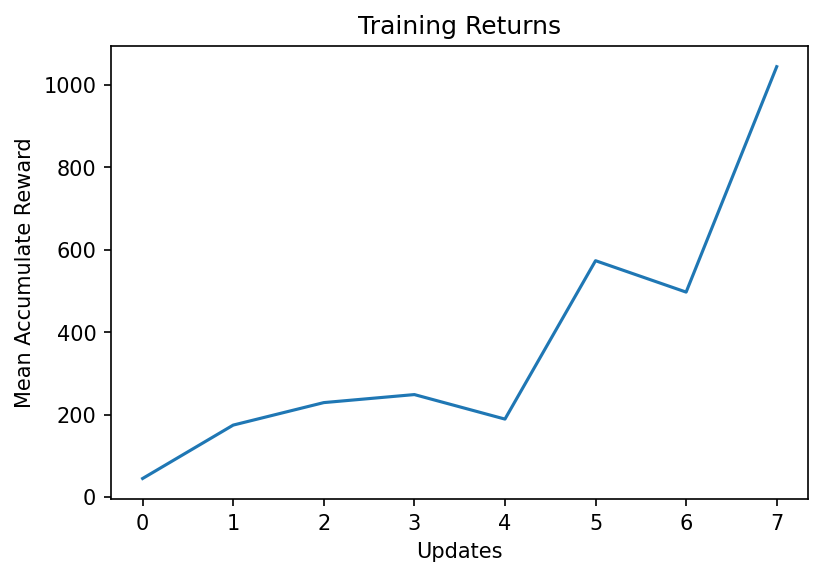

In [ ]:
plotRes(testRes)

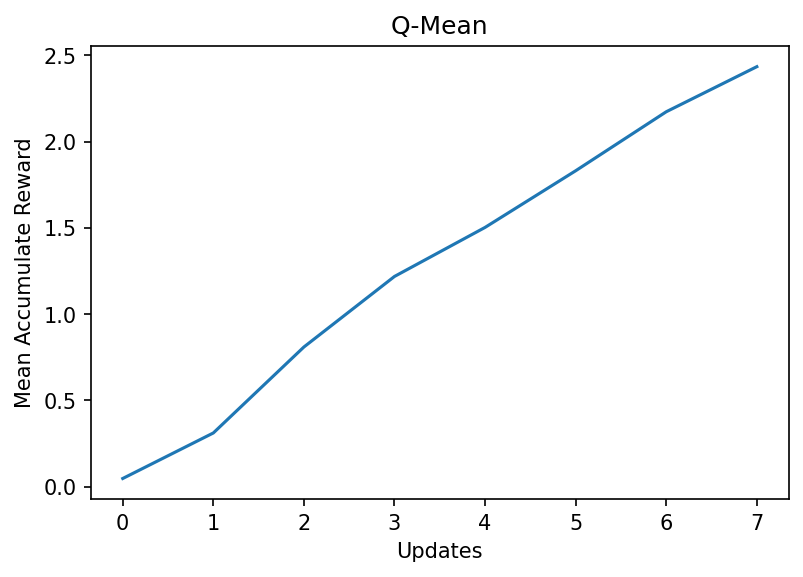

In [ ]:
plotRes(testQFix, "Q-Mean")

Reward Accumulated:4280.0, Mean:856.0. Q_mean 2.667
Update 0 of 199999
Reward Accumulated:5440.0, Mean:1360.0. Q_mean 2.946
Update 25000 of 199999
Reward Accumulated:5300.0, Mean:1325.0. Q_mean 3.123
Update 50000 of 199999
Reward Accumulated:5960.0, Mean:1490.0. Q_mean 3.279
Update 75000 of 199999
Reward Accumulated:5780.0, Mean:1445.0. Q_mean 3.448
Update 100000 of 199999
Reward Accumulated:5360.0, Mean:893.33. Q_mean 3.602
Update 125000 of 199999
Reward Accumulated:7320.0, Mean:1830.0. Q_mean 3.753
Update 150000 of 199999
Reward Accumulated:7880.0, Mean:1970.0. Q_mean 3.937
Update 175000 of 199999


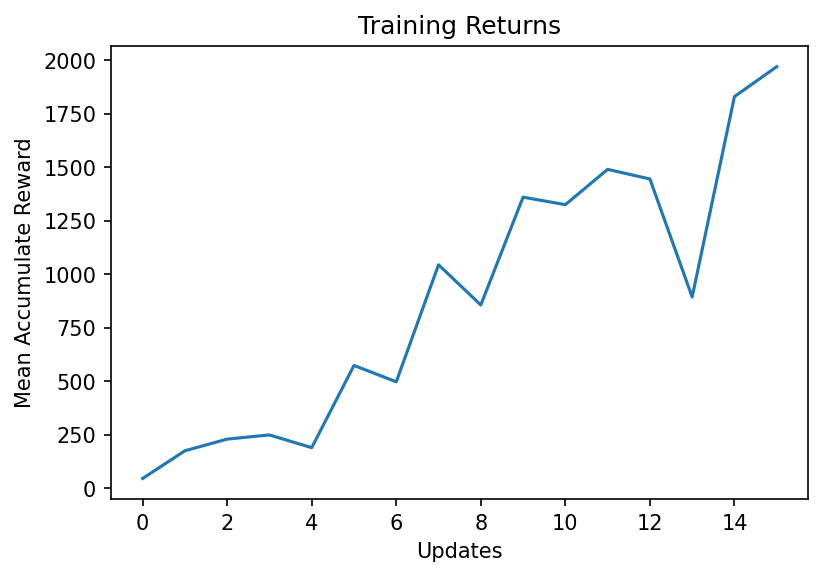

In [ ]:
testRes, testQFix = train(actor, memoryReplay, learner, testRes, testQFix)
plotRes(testRes)

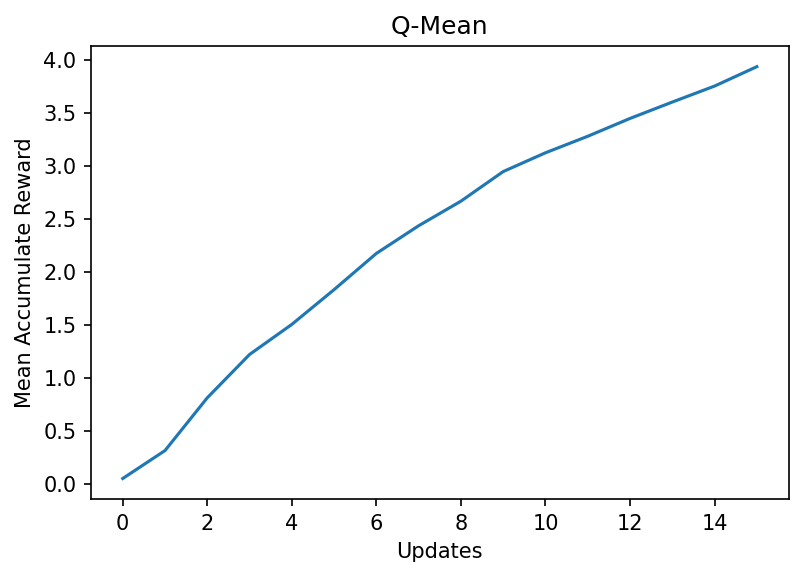

In [ ]:
plotRes(testQFix, "Q-Mean")

## Estudio - Entrenamiento DQN sin uso de red objetivo

Para estudiar el fenómeno que se indicaba previamente durante la presentación de $\delta_{\text{DQN}}$, se hace un entrenamiento de una red sin el uso del otro conjunto de parámetros $\theta_i'$. En sí se hará la actualización con

$\delta_{\text{Q-Learning}} = R_{t+1} + \max_{a'} Q(S_{t+1}, a'; \theta_i) - Q(S_{t}, A_t; \theta_i) $

Para esto se modifica solamente el método de .trainStep() y .target() del Aprendíz. 

In [ ]:
class LearnerDQNMod():
    """
    Actor that manages the samples and learn the transitions
    with the policy passed.

    Parameters
    ----------
    """
    def __init__(self,
                policy,
                memory,
                mini_batch_size:int = MINI_BATCH_SIZE,
                gamma:float = GAMMA,
                update_target:int = UPDATE_TARGET,
                learning_rate:float = LEARNING_RATE,
                momentum:float = G_MOMENTUM,
                clip_error:float = CLIP_ERROR,
                optimizer:str = 'adam',
                seed:int = -1,
                device = torch.device('cpu'),
                ):

        self.seed = seed if seed >= 0 else None
        self.rg = np.random.Generator(np.random.PCG64(self.seed))

        self.gamma = gamma
        self.clip = clip_error
        self.miniBatch_size = mini_batch_size

        self.device = device
        self.online_net = policy.to(device)
        self.n_actions = policy.outputs
        
        self.memory = memory # Reference

        if optimizer == 'rmsprop':
            self.optimizer = optim.RMSprop(self.online_net.parameters(), 
                                        lr= learning_rate, alpha=momentum,
                                        eps=0.00001, centered=True)

        elif optimizer == 'adam':
            self.optimizer = optim.Adam(self.online_net.parameters(),
                                        lr=learning_rate,)

        self.steps = 0

    def trainStep(self):
        """
        Executes a simple learning step with a mini batch from
        the memory replay.\n
        It updates its target network automagically.
        """
        s1, a, r, s2, t = self.memory.Sample(self.miniBatch_size, self.device)
        actions_hot = F.one_hot(a, num_classes=self.n_actions)
        q_online = self.online_net.forward(s1)
        q_online = torch.mul(q_online, actions_hot)
        q_target = self.dqnTarget(s2, r, t)
        q_target = torch.mul(q_target, actions_hot)

        # Hubber Loss
        loss = F.smooth_l1_loss(q_online, q_target, reduction='mean')

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.steps += 1

    def dqnTarget(self, s2, r, t):
        with torch.no_grad():
            model_out = self.online_net.forward(s2) # Mod in here
            Qs2_max = model_out.max(1)[0]
            target = r + torch.mul(t, Qs2_max).mul(self.gamma).reshape(r.shape)
        return target.unsqueeze(1)

    def onlineModel(self, cpu:bool = False):
        return self.online_net.getState(cpu)

    def updateOnlineModel(self, new_state):
        self.online_net.updateState(new_state)

In [ ]:
## New actors
net2 = atariDQN(actions = actions)
memoryReplay.reset() # Just reseting to save memory
actor2 = ActorDQN(game, actions, net2, device=DEVICE)
learner2 = LearnerDQNMod(net2, memoryReplay, device=DEVICE)

actor2.newGame()
fillMem(actor2, memoryReplay)

Game seaquest is set up!
Actions given 6 don't match the environment 18


In [ ]:
testRes2, testQFix2 = train(actor2, memoryReplay, learner2)

Reward Accumulated:220.0, Mean:55.0. Q_mean 0.025
Update 0 of 199999
Reward Accumulated:80.0, Mean:40.0. Q_mean 2.379
Update 25000 of 199999
Reward Accumulated:1500.0, Mean:83.33. Q_mean 1.136
Update 50000 of 199999
Reward Accumulated:0.0, Mean:0.0. Q_mean 2.363
Update 75000 of 199999
Reward Accumulated:200.0, Mean:50.0. Q_mean 1.66
Update 100000 of 199999
Reward Accumulated:0.0, Mean:0.0. Q_mean 2.04
Update 125000 of 199999
Reward Accumulated:1440.0, Mean:80.0. Q_mean 2.789
Update 150000 of 199999
Reward Accumulated:2180.0, Mean:181.67. Q_mean 1.881
Update 175000 of 199999


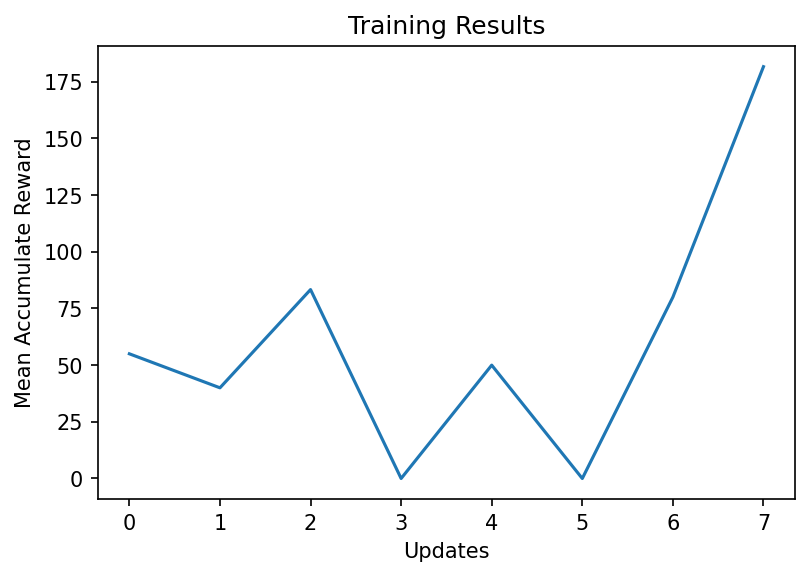

In [ ]:
plotRes(testRes2, "Training Results")

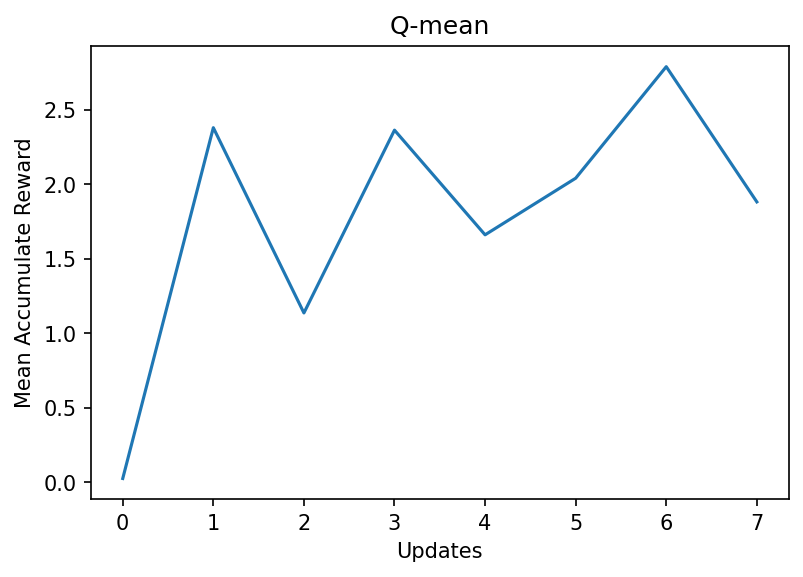

In [ ]:
plotRes(testQFix2, "Q-mean")

Reward Accumulated:1920.0, Mean:147.69. Q_mean 1.956
Update 0 of 199999
Reward Accumulated:1260.0, Mean:66.32. Q_mean 1.887
Update 25000 of 199999
Reward Accumulated:1600.0, Mean:160.0. Q_mean 2.258
Update 50000 of 199999
Reward Accumulated:0.0, Mean:0.0. Q_mean 1.891
Update 75000 of 199999
Reward Accumulated:360.0, Mean:120.0. Q_mean 1.838
Update 100000 of 199999
Reward Accumulated:1960.0, Mean:196.0. Q_mean 2.162
Update 125000 of 199999
Reward Accumulated:2260.0, Mean:226.0. Q_mean 1.654
Update 150000 of 199999
Reward Accumulated:1680.0, Mean:168.0. Q_mean 1.983
Update 175000 of 199999


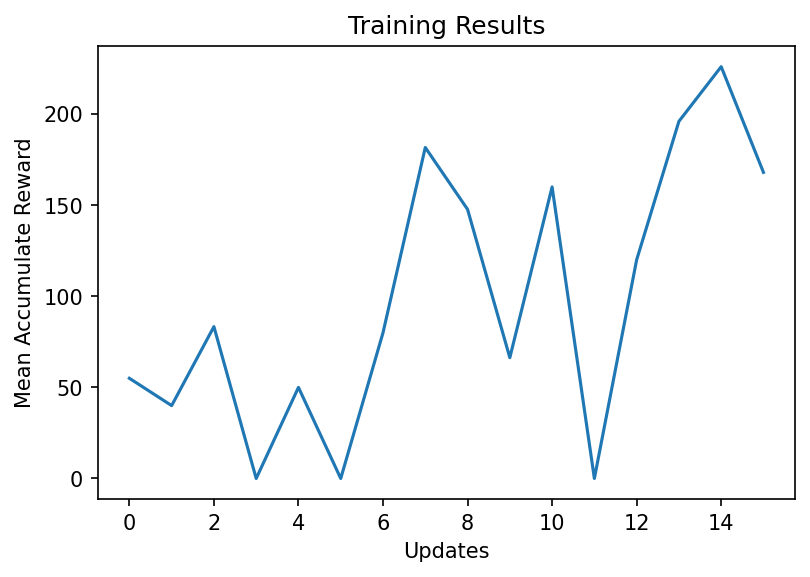

In [ ]:
testRes2, testQFix2 = train(actor2, memoryReplay, learner2, testRes2, testQFix2)
plotRes(testRes2, "Training Results")

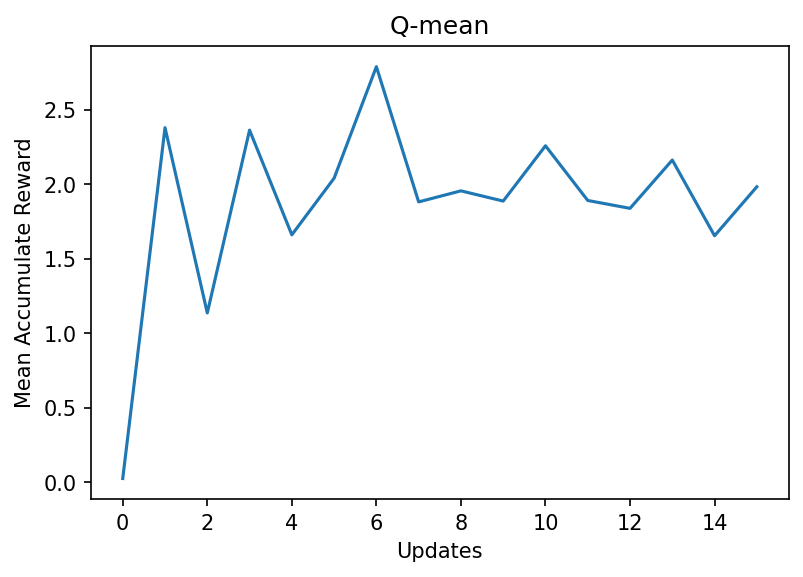

In [ ]:
plotRes(testQFix2, "Q-mean")

### Observaciones
De los resultados mostrados en este solo ejemplo se puede ver a través de los valores *Q-mean* el comportamiento oscilante de DQN cuando no se utiliza la red objetivo (*target network*) para el calculo de $\delta_{\text{DQN}}$. Aunque un experimento es poco para comenzar a concluir, bajo las mismas condiciones también se puede comenzar a ver un pobre rendimiento de la red en linea al momento de las prubas cuando no es entrenada con la red objetivo najo las mismas iteraciones. Sacando solo un poco de ventaja contra una politica aleatoria en *Seaquest* de puntuación promedio de 110 (Esto del paper original de Mnih et al. sobre DQN).

### Salvar el modelo entrenado
Las siguientes son para salvar en tu unidad de google drive el modelo que hayas obtenido y demás información.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model = learner.onlineModel
torch.save(model, "/content/drive/MyDrive/MyDQNModel.model")